In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

from mpl_toolkits.mplot3d import Axes3D  #### is this required for 3D
from IPython.display import HTML ## to make in-browser HTML5 animations

#### Quasiparticle Force 

$$ \vec{F} = 
\begin{cases}
\frac{-f_{mag}}{r_{12}^{3}} \,\vec{r}_{12} & r > 2d\\
f_{mag} \left( -\frac{1}{r_{12}^{3}} + \frac{d^{2}}{r_{12}^{5}} \right) \vec{r}_{12} & \epsilon d < r < 2d\\
f_{mag} \left( -\frac{1}{(\epsilon d)^{2}} + \frac{d^{2}}{(\epsilon d)^{4}} \right) \frac{\vec{r}_{12}}{|r_{12}|} & r < \epsilon d
\end{cases}
$$


In [2]:
def force(r1,r2,d=0.1,fmag=1.0):  #inputs 1-D vectors length 3
    epsilon = 0.01
    x1, y1, z1 = r1
    x2, y2, z2 = r2
    rsq = (x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2
    if (rsq > 4*d**2):
        f = fmag*(-1/(rsq**1.5))
    elif (rsq > (d*epsilon)**2):
        f = fmag*( (-1/(rsq**1.5)) + (d**2)/(rsq**2.5))
    else:
        f = fmag*(d**2)/((epsilon*d)**4)/(rsq**0.5)
    return np.array([f*(x1-x2), f*(y1-y2), f*(z1-z2)])

### Load the arrays for two spherical masses


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')


### Load spherical mass 1 ###
# load file with arrays for 100 particles
#npzfile = np.load("pos_vel_n100_d05_f04.npz")
npzfile = np.load('pos_vel_n100_d05_f04.npz')
posArr1 = npzfile['posArr']
velArr1 = npzfile['velArr']
massArr1 = npzfile['massArr']
npart1 = len(massArr1)

### Load spherical mass 2 ###
# load file with arrays for 300 particles
#npzfile = np.load("pos_vel_n300_d05_f04.npz")
npzfile = np.load('pos_vel_n300_d05_f04.npz')
posArr2 = npzfile['posArr']
velArr2 = npzfile['velArr']
massArr2 = npzfile['massArr']
npart2 = len(massArr2)

d = 0.50  ### Same as the code that made the spherical mass
fmag = 0.40  ### Same as the code that made the spherical mass
dt = 0.005 ## Important to make this small enough


#### Combine the arrays for the individual spheres ####

The posArr array from mass 1 and mass 2 are combined into a single posArr. In addition, in the massArr array, we will add a column to indicate which mass the particles belong to.


In [4]:
### Make new posArr, velArr, and massArr arrays by combining the two

massArr = np.zeros(shape=(npart1+npart2,2))
massArr[0:npart1,0] = massArr1
massArr[0:npart1,1] = 1 ### group index, this is for the first sphere
massArr[npart1:,0] = massArr2
massArr[npart1:,1] = 2 ### group index, this is for the second sphere

velArr = np.zeros(shape=(npart1+npart2,3))
velArr[0:npart1,:] = velArr1
velArr[npart1:,:] = velArr2

posArr = np.zeros(shape=(npart1+npart2,3))
posArr[0:npart1,:] = posArr1
posArr[npart1:,:] = posArr2

nparticles = npart1+npart2

In [5]:
# Set Initial conditions
posArr[0:npart1, :] = posArr[0:npart1, :] + [-3.0, -3.0, 1.75]
velArr[0:npart1, :] = velArr[0:npart1, :] + [1.8, 1.8, 0]

(-3.5, 3.5)

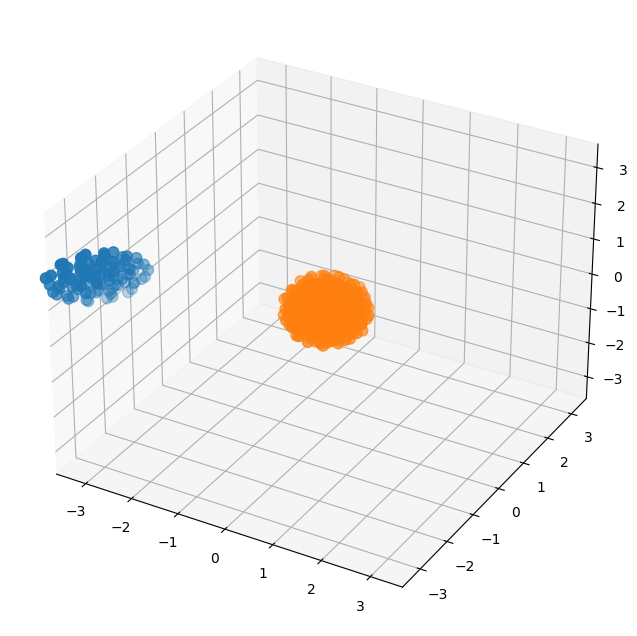

In [6]:
%matplotlib inline
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(posArr[0:npart1,0], posArr[0:npart1,0],posArr[0:npart1,2], s=60)
ax.scatter(posArr[npart1:,0],posArr[npart1:,1],posArr[npart1:,2], s=60)
ax.set_zlim3d([-3.5,3.5])
ax.set_xlim3d([-3.5,3.5])
ax.set_ylim3d([-3.5,3.5])

Update routine
$$ \vec{v}_{t+1/2} = \vec{v}_{t} + \frac{(\Delta t)}{2} \vec{a}[\vec{r}_{t}] $$
$$ \vec{r}_{t+1} = \vec{r}_{t} + (\Delta t) \vec{v}_{t+1/2} $$
$$ \vec{v}_{t+1} = \vec{v}_{t+1/2} + \frac{(\Delta t)}{2} \vec{a}[\vec{r}_{t+1}] $$

#### Set up the simulation ####

The number of frames is set in the last line (i.e.`frames=15` ). The number of time steps per frame is set in the while loop condition (i.e. `t < 10`)

In [13]:
%matplotlib notebook
frict = 0.001 # near zero or at zero

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
pts = [ ax.scatter([],[],[], s=60, facecolor=(0.9,0.5,0.0,0.3)) for i in range(npart1) ]
pts = pts + [ ax.scatter([],[],[], s=60, facecolor=(0.9,0.1,0.0, 0.3)) for i in range(npart2) ]
ax.set_zlim3d([-3.5,3.5])
ax.set_xlim3d([-3.5,3.5])
ax.set_ylim3d([-3.5,3.5])

def init():
    for i in range(nparticles):
        pts[i].set_offsets([posArr[i,0], posArr[i,1]])
        pts[i].set_3d_properties(posArr[i,2], zdir='z')
    return pts

def animate(frame):
    step = 0
    while (step < 10):
        for i in range(nparticles):
            f12 = np.array([0,0,0])
            for j in np.setdiff1d(range(nparticles)):
                f12 = f12 + force(posArr[i,:],posArr[j,:],d,fmag)
            velArr[i,:] += velArr[i,:] + f12*dt/2
            posArr[i,:] += posArr[i,:] + velArr[i,:]*dt
            for j in np.setdiff1d(range(nparticles)):
                f12 = f12 + force(posArr[i,:],posArr[j,:],d,fmag)
            velArr[i,:] += velArr[i,:] + f12*dt/2
        step += 1
    for i in range(nparticles):
        pts[i].set_offsets([posArr[i,0], posArr[i,1]])
        pts[i].set_3d_properties(posArr[i,2], zdir='z')
    print('{}'.format(frame+1),end='')
    return pts

anim = animation.FuncAnimation(fig, animate, frames=25, init_func=init, blit=True)
anim.save('test.mp4')

<IPython.core.display.Javascript object>

TypeError: _setdiff1d_dispatcher() missing 1 required positional argument: 'ar2'